In [1]:
from osgeo import gdal,ogr
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
import fiona
import rasterio
import rasterio.plot
import math
import matplotlib.patches as patches
import cv2 as cv
import pandas as pd

## Dagahaley

In [2]:
shp = '/efs/data/jpb/data/tiles/raw_data/polygons/Dagahaley_Structures/Dagahaley_Structures.shp'
raster = '/efs/data/jpb/data/tiles/raw_data/images/Dagahaley_Ortho_GEO.tif'

In [3]:
gdf = gpd.read_file(shp)
gdf.crs

{'init': 'epsg:4326'}

In [4]:
src = rasterio.open(raster)
src.crs

CRS({'init': 'epsg:4326'})

The global coordinate methods match so we don't need to change anything

In [5]:
gdf.head()

,TYPE,geometry
0,Structure,POLYGON ((40.28032980900008 0.1875338450000754...
1,Structure,POLYGON ((40.28033992100006 0.1875455820000411...
2,Structure,POLYGON ((40.28028606400005 0.1870657620000316...
3,Structure,"POLYGON ((40.28029796200008 0.187026501000048,..."
4,Structure,POLYGON ((40.28017553800004 0.1873021610000478...


Extract polygons. Multipolygons also occasionally feature in the dataset due to the way they were labelled and have to be extracted in a different way.

In [6]:
errors = []
g = gdf['geometry']
all_coords = []
for j in range(len(g)):
    coord = []
    try:
        "Handling of polygons"
        for i in g[j].boundary.coords:
            coord.append(i)
    except:
        "Handling of multipolygons"
        for i in g[j].boundary:
            for k in i.coords:
                coord.append(k)
        errors.append(j)
    all_coords.append(coord)

In [7]:
errors

[16846, 17480, 17534, 19100, 19284, 19318, 19363, 20195, 21482]

In [8]:
def world2Pixel(geoMatrix, x, y):
    """
    Uses a gdal geomatrix (.transform) to calculate
    the pixel location of a geospatial coordinate
    """
    ulX = geoMatrix[2]
    ulY = geoMatrix[5]
    xDist = geoMatrix[0]
    yDist = geoMatrix[4]
    rtnX = geoMatrix[1]
    rtnY = geoMatrix[3]
    pixel = int((x - ulX) / xDist)
    line = int((ulY - y) / xDist)
    return (line,pixel)

In [9]:
gt = src.transform

pixel_coords = []
bboxes = []
for i in all_coords:
    coords = []
    for j in i:
        coords.append(np.array(world2Pixel(gt,j[0],j[1])))
    coords = np.array(coords)
    pixel_coords.append(coords)
    bbox = np.array([np.min(coords[:,0]),np.min(coords[:,1]),np.max(coords[:,1])-np.min(coords[:,1]),np.max(coords[:,0])-np.min(coords[:,0])])
    bboxes.append(bbox)

In [10]:
pc = np.array(pixel_coords)
bb = np.array(bboxes)

In [11]:
src_array = src.read()

In [12]:
src_swap = np.swapaxes(src_array,0,2)
image = np.swapaxes(src_swap,0,1)

In [13]:
upper_left = []
for i in pc:
    upper_left.append(i[0])

In [14]:
ul = np.array(upper_left)

Plot the positions of the structures on top of the image. **Note:** The two line up correctly if swap around the x and y labels.

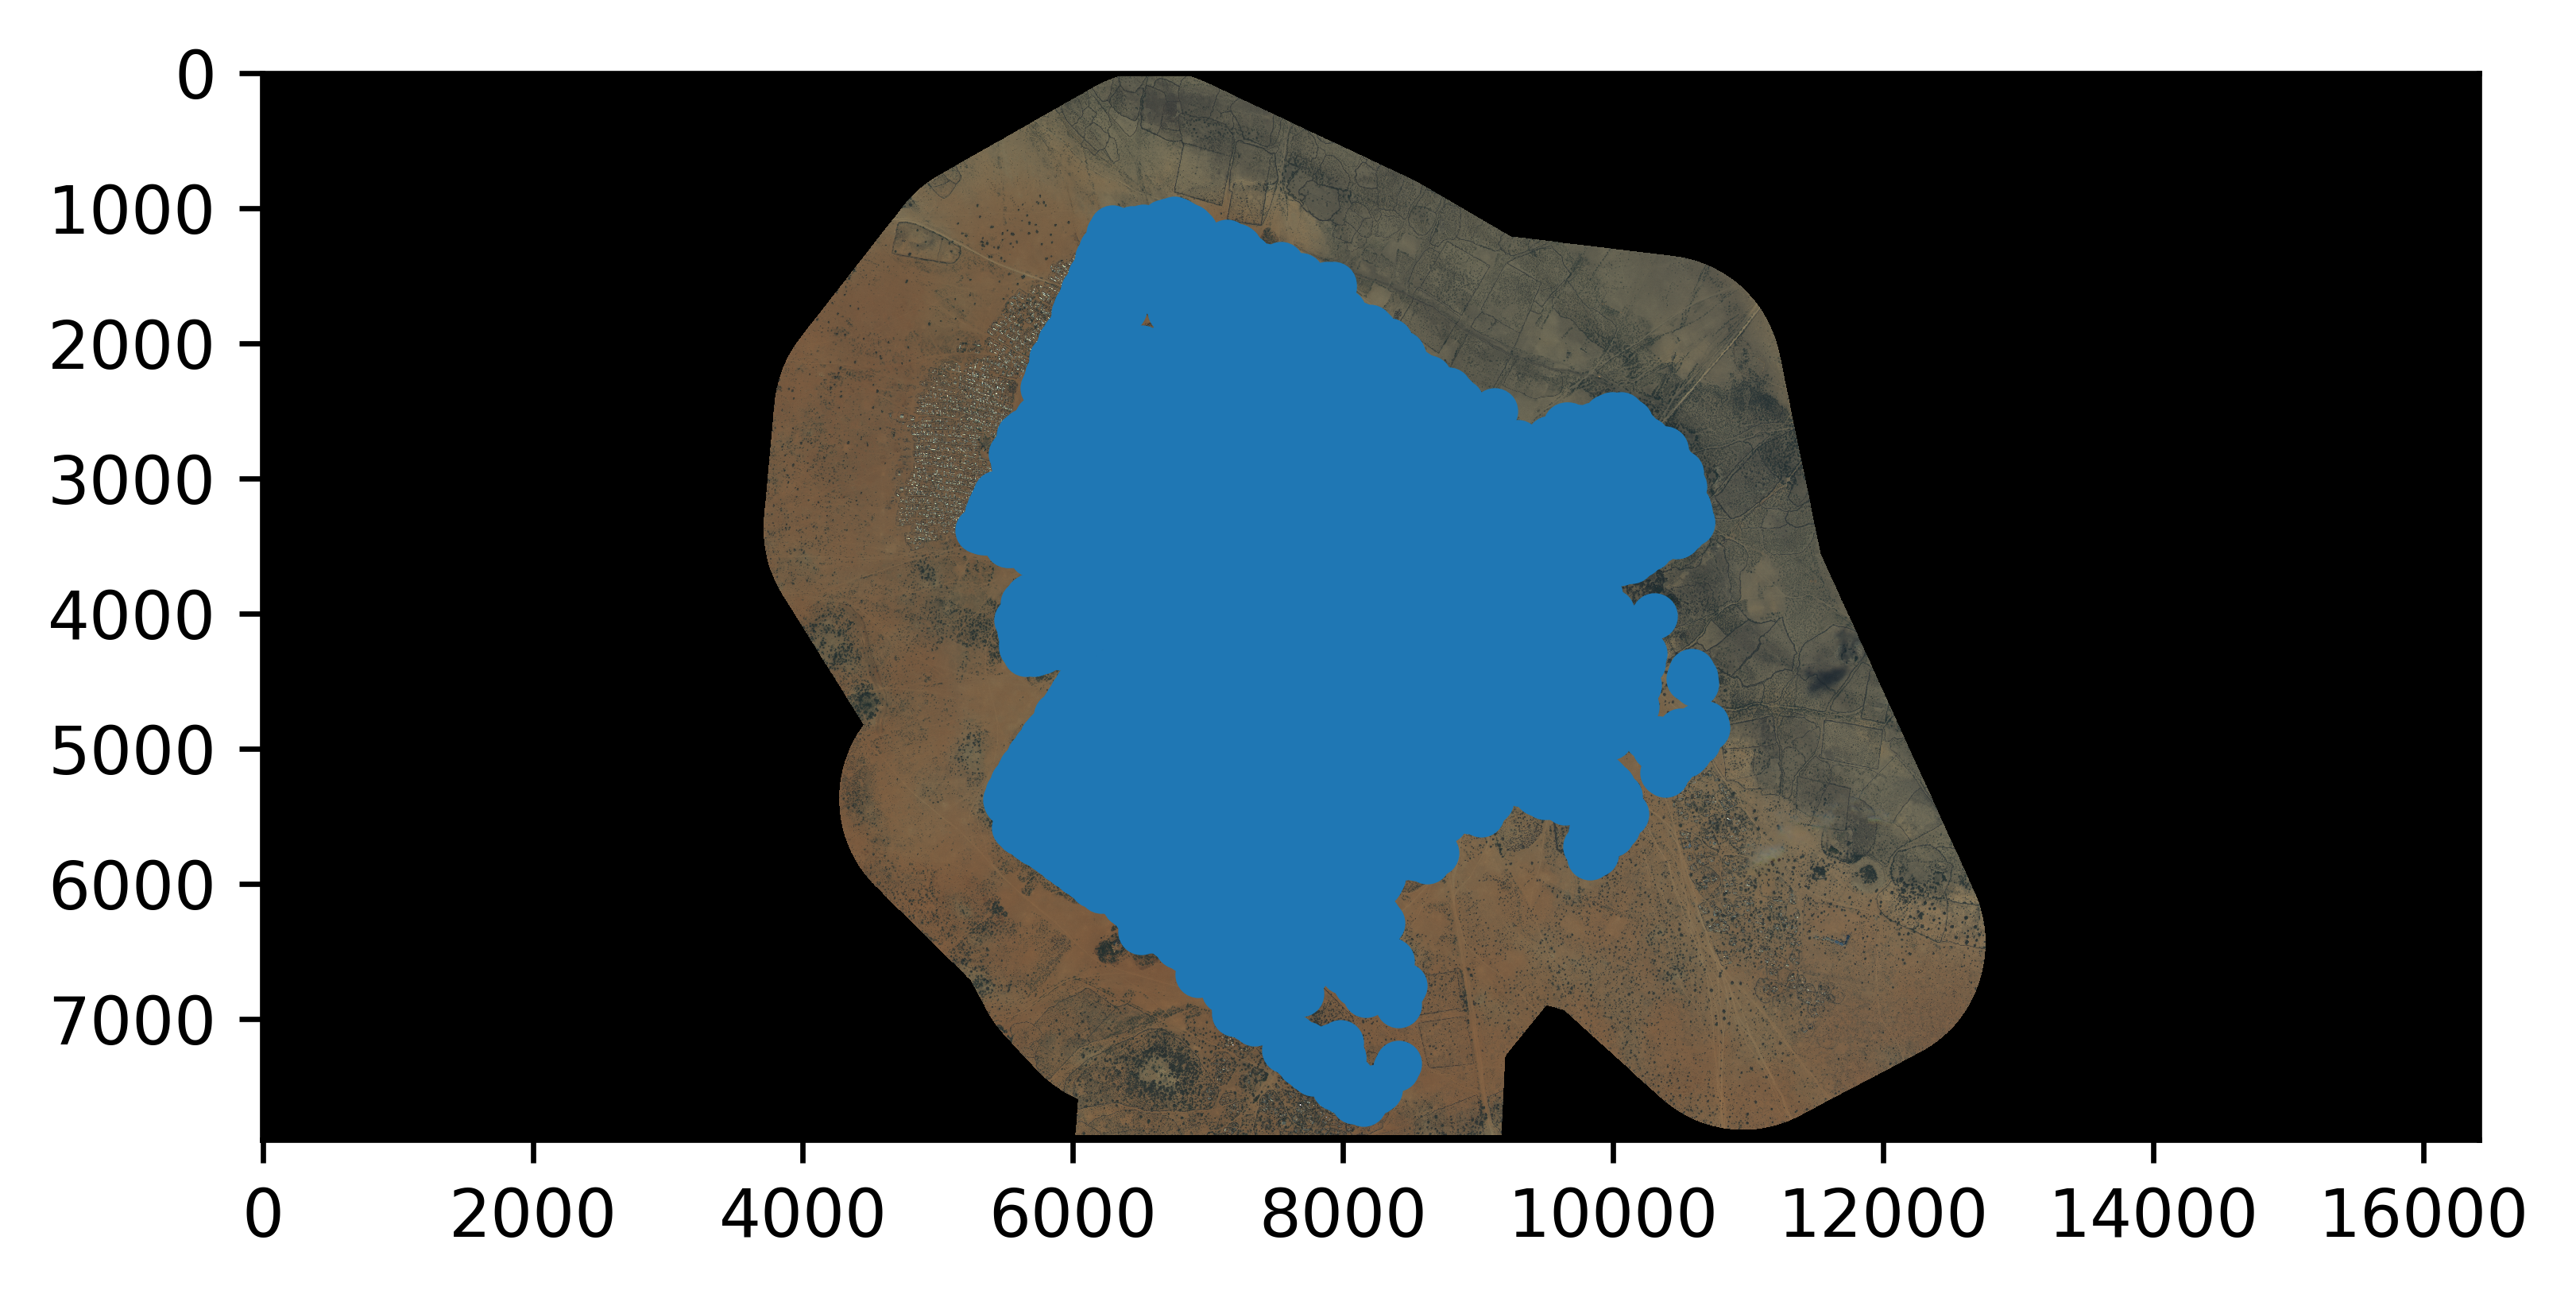

In [16]:
plt.figure(dpi=600)
plt.imshow(image)
plt.scatter(ul[:,1],ul[:,0])

Since we now have two correctly overlapping datasets we should be able to tile this.

Up to here we have bboxes which is an array of bbox coordinates in the form `[upper_left_row,upper_left_column,column_width,row_height]` which is given in terms of pixel coordinates.

In [17]:
tile_size = (300,300)
offset = (300,300)

Tiling

In [57]:
tile = []
anno = []
upper_corner = []
for i in range(int(math.ceil(image.shape[0]/(offset[1] * 1.0)))):
    possible_h = np.where(np.logical_and(bb[:,0]>i*offset[1],(bb[:,0]+bb[:,2])<min(offset[1]*i+tile_size[1], image.shape[0])))[0]
    for j in range(int(math.ceil(image.shape[1]/(offset[0] * 1.0)))):
        possible_w = np.where(np.logical_and(bb[possible_h,1]>offset[0]*j,(bb[possible_h,1]+bb[possible_h,3])<min(offset[0]*j+tile_size[0], image.shape[1])))[0]
        cropped_img = image[offset[1]*i:min(offset[1]*i+tile_size[1], image.shape[0]), offset[0]*j:min(offset[0]*j+tile_size[0], image.shape[1])]
        anno_uncorrected = np.array(bb[possible_h[possible_w]]-np.array([offset[1]*i,offset[0]*j,0,0]))
        anno.append(anno_uncorrected)
        upper_corner.append([offset[1]*i,offset[0]*j])
        tile.append(cropped_img)

In [61]:
camp_tile = []
camp_anno = []
camp_upper_corner = []
for idx, i in enumerate(anno):
    if len(i) != 0:
        camp_anno.append(i)
        camp_tile.append(tile[idx])
        camp_upper_corner.append(upper_corner[idx])

In [87]:
i = 50

2400
9600


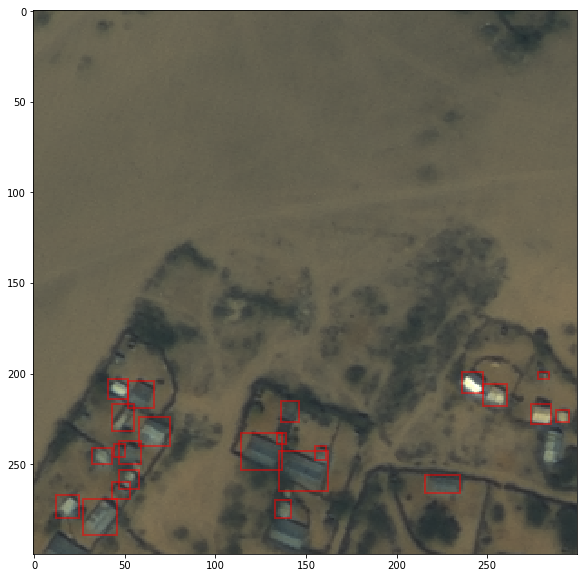

In [91]:
im = camp_tile[i]

# Create figure and axes
fig,ax = plt.subplots(1)

# Display the image
ax.imshow(im)

# Create a Rectangle patch
for box in camp_anno[i]:
    rect = patches.Rectangle((box[1],box[0]),box[2],box[3],
                             linewidth=2,
                             edgecolor='r',
                             alpha=.5,
                             facecolor='none')
    ax.add_patch(rect)
    #plt.plot([box[1],box[1]+box[2]],[box[0],box[0]+box[3]])
fig.set_size_inches(10,10)
#plt.savefig('./dagahaley_{}'.format(i))

Now write these tiles and annotations to a file.

In [93]:
filenames = []
bbox = []
for i in range(len(camp_anno)):
    if camp_tile[i].shape == (300,300,3):
        cv.imwrite('/efs/data/jpb/data/tiles/Dagahaley/images/'+'dagahaley-x{}y{}.png'.format(camp_upper_corner[i][0],camp_upper_corner[i][1]),camp_tile[i])
        for j in camp_anno[i]:
            filenames.append('dagahaley-x{}y{}.png'.format(camp_upper_corner[i][0],camp_upper_corner[i][1]))
            # note the switch around in the bbox coords
            bbox.append([j[1],j[0],j[2],j[3]])
    else:
        print ('skipping tile {}'.format(i))

In [94]:
bb = np.array(bbox)

In [95]:
data = {'filename':filenames, 'xmin':bb[:,0],'ymin':bb[:,1],'width':bb[:,2],'height':bb[:,3]}

In [96]:
df = pd.DataFrame(data)

In [97]:
df.head()

,filename,xmin,ymin,width,height
0,dagahaley-x900y6000.png,273,281,9,10
1,dagahaley-x900y6000.png,290,245,9,9
2,dagahaley-x900y6300.png,47,284,9,9
3,dagahaley-x900y6300.png,101,275,13,14
4,dagahaley-x900y6300.png,135,252,10,11


In [98]:
df.to_csv('/efs/data/jpb/data/tiles/Dagahaley/annotations/annotations.csv')

## Testing

In [129]:
im_file = df['filename'][150]

In [130]:
im = cv.imread('/efs/data/jpb/data/tiles/Dagahaley/images/' + im_file)

In [131]:
annos = df[df['filename'] == im_file].reset_index()

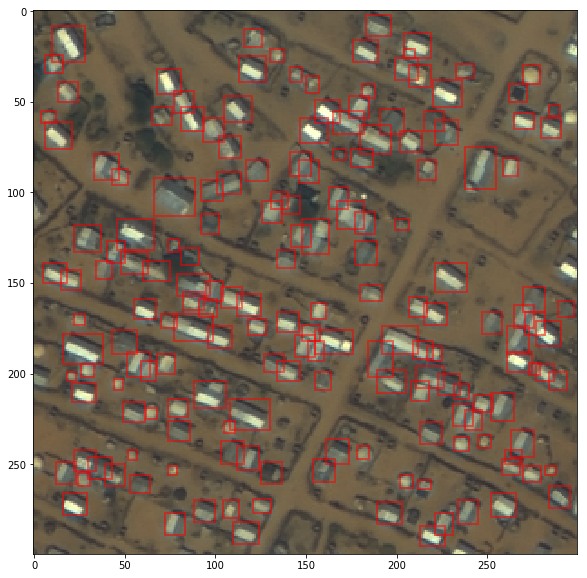

In [132]:
# Create figure and axes
fig,ax = plt.subplots(1)

# Display the image
ax.imshow(im)

# Create a Rectangle patch
for i in range(len(annos)):
    box = [annos['xmin'][i], annos['ymin'][i], annos['width'][i], annos['height'][i]]
    rect = patches.Rectangle((box[0],box[1]),box[2],box[3],
                             linewidth=2,
                             edgecolor='r',
                             alpha=.5,
                             facecolor='none')
    ax.add_patch(rect)
    #plt.plot([box[1],box[1]+box[2]],[box[0],box[0]+box[3]])
fig.set_size_inches(10,10)
#plt.savefig('./dagahaley_missing{}'.format(i))